In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

## Part 1 : Building an optimized portfolio to offset market risk



### A) Evolution of Stock Prices

#### A.1) Paths of Stock Prices

In [2]:
# Initialisation of Parameters
t0 = 0
S0 = 1    # stock price at t = 0
r = 0.05  # risk-free rate
sigma = 0.5  # volatility
T = 5        # Maturity
N = 100      # Number of steps
K = 1.5      # Strike
t = np.linspace(0, T, N)
dt = T / N
Nmc = 1000 # number of paths

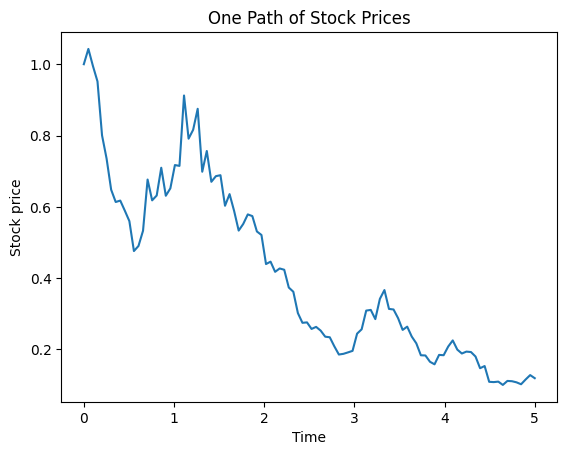

In [3]:
def GraphOnePath():

    S = np.zeros(N)
    S[0] = 1
    for i in range(N-1):
        S[i+1] = S[i] * np.exp((r - sigma**2 / 2) * dt + np.sqrt(dt) * sigma * np.random.normal(0, 1))

    plt.plot(t, S)
    plt.xlabel('Time')
    plt.ylabel('Stock price')
    plt.title('One Path of Stock Prices')

GraphOnePath()
        

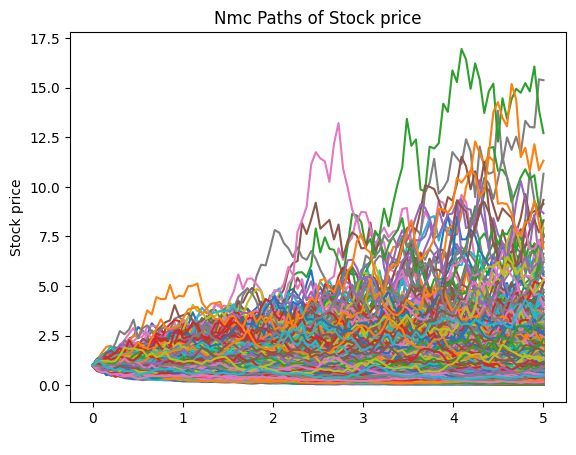

In [4]:
def GraphNmcPaths():
    t = np.linspace(0, T, N)
    dt = T / N
    S = np.zeros((Nmc, N))
    # S[:, 0] = np.ones(Nmc)
    S[:,0] = S0
    for i in range(N-1):
        S[:, i+1] = S[:, i] * np.exp((r - sigma**2 / 2) * dt + np.sqrt(dt) * sigma * np.random.normal(0, 1, Nmc)) # np.random.normal(0, 1, Nmc): array of size Nmc with random samples of N(0,1)
    for i in range(Nmc):
        plt.plot(t, S[i])
    plt.xlabel('Time')
    plt.ylabel('Stock price')
    plt.title('Nmc Paths of Stock price')
GraphNmcPaths()

#### A.2) Expected value $E(S_T)$ and Variance $\text{Var}(S_T)$ of Stock Price

In [5]:
def Moment():
    t = np.linspace(0, T, N)
    dt = T / N
    S = np.zeros((Nmc, N))
    S[:, 0] = S0
    count = 0
    for i in range(N-1):
        S[:, i+1] = S[:, i] * np.exp((r - sigma**2 / 2) * dt + np.sqrt(dt) * sigma * np.random.normal(0, 1, Nmc))

    obs_E_ST = np.mean(S[:, -1]) # Observed / Empirical Expected Value
    obs_Var_ST = np.var(S[:, -1]) # Observed / Empirical Variance

    return obs_E_ST, obs_Var_ST
    
    
Moment()

(np.float64(1.3442440324432041), np.float64(7.07364942707141))

#### A.3) Comparison with the theorical formulas

##### Theoratical Expected Value: $E(S_T) = S_0 \cdot e^{rT}$ and $ \text{Var}(S_T) = S_0^2 \cdot e^{2rT} \cdot \left( e^{\sigma^2 T} - 1 \right)$

In [6]:
th_E_ST = S0 * np.exp(r * T)
th_Var_ST = S0**2 * np.exp(2 * r * T) * (np.exp(sigma**2 * T) - 1)

In [7]:
# Expected Value MSE
mse_E_ST = (Moment()[0] - th_E_ST)**2 / 2
mse_Var_ST = (Moment()[1] - th_Var_ST)**2 / 2
df = pd.DataFrame({
    'Expected Value': [Moment()[0], th_E_ST],
    'Variance': [Moment()[1], th_Var_ST]
}, index = ['Empirical', 'Theoratical'])
print(df.head())

print(f"Mean Squared Error for Expected Value:{mse_E_ST}")
print(f"Mean Squared Error for Variance:{mse_Var_ST}")


             Expected Value  Variance
Empirical          1.332756  2.754409
Theoratical        1.284025  4.105881
Mean Squared Error for Expected Value:0.00010007802278542902
Mean Squared Error for Variance:0.4157753695872064


### B) Hedging Portfolio

##### The theoretical value of a European Call option is determined by the following formula:

\begin{equation}
V^{BS}(S_i, t_i) = S_iN(d_1(S_i, t_i)) - Ke^{-r(T-t_i)}N(d_2(S_i, t_i))
\end{equation}

\begin{equation}
d_1(S_i, t_i) = \frac{\ln(S_i/K) + (r + \frac{\sigma^2}{2})(T - t_i)}{\sigma\sqrt{T - t_i}} \qquad
d_2(S_i, t_i) = \frac{\ln(S_i/K) + (r - \frac{\sigma^2}{2})(T - t_i)}{\sigma\sqrt{T - t_i}}
\end{equation}


- **Initial Calculations**
  1. **Calculate the initial number of shares (or quantity of the underlying asset):**
     $A_0 = \frac{\partial V}{\partial S}\bigg|_{t=0} = N\left(d_1(S_0;0)\right)$
     
  3. **Set the initial cash value:**
     $B_0 = 1 \text{ (arbitrary choice)}$ 

  4. **Initial portfolio value:**
    $P_0 = A_0 S_0 + B_0$
     
  5. **Calculate the discounted initial portfolio value:**
     $P_{\text{discounted},0} = V_0$
     


In [8]:
def d1(t, S, K, T, r, sigma):
    # Avoid division by zero and handle invalid values
    if t == T or sigma == 0:
        return 0
    else:
        return (np.log(S / K) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * np.sqrt(T - t))

In [9]:
def d2(t, S, K, T, r, sigma):
    return d1(t, S, K, T, r, sigma) - sigma * np.sqrt(T - t)

In [10]:
def Call_BS(t, S, K, T, r, sigma):
    if t == T:
        return max(S-K, 0)
    else:
        return S * norm.cdf(d1(t, S, K, T, r, sigma)) - K * np.exp(-r * T) * norm.cdf(d2(t, S, K, T, r, sigma))

In [11]:
def Delta_BS(t,S,K,T,r,sigma):
    if t == T:
        return 1
    else:
        return norm.cdf(d1(t, S, K, T, r, sigma))
# print(Vega_BS(t,S0,K,T,r,sigma))

#### B.1) Parameters initialization

In [12]:
# Stock price
S = np.zeros(N)
S0 = 1
S[0] = S0

In [13]:
# Initial Number of Shares / Stocks:
A = np.zeros(N)
A0 = Delta_BS(t0,S0,K,T,r,sigma)
A[0] = A0

In [14]:
# Initial Cash:
B = np.zeros(N)
B0 = 1
B[0] = B0

In [15]:
# Intitial Portfolio
P = np.zeros(N)
P0 = A0 * S0 + B0
P[0] = 0

In [16]:
# Intitial Discounted Portfolio
P_discount = np.zeros(N)
P_discount[0] = Call_BS(t0, S0, K, T, r, sigma)

In [17]:
# Option Price
V_BS = np.zeros(N)
V_BS[0] = Call_BS(t[0],S[0],K,T,r,sigma)

#### B.2) Simulation

In [18]:
for i in range(N-1):
    S[i+1] = S[i] * np.exp((r - 0.5 * sigma**2) * dt + np.sqrt(dt) * sigma * np.random.normal(0, 1))
    A[i+1] = Delta_BS(t[i+1],S[i+1],K,T,r,sigma)
    B[i+1] = (A[i] - A[i+1]) * S[i+1] + B[i] * (1 + r * dt)
    P[i+1] = A[i+1] * S[i+1] + B[i+1] # self-financing condition
    V_BS[i+1] = Call_BS(t[i+1],S[i+1],K,T,r,sigma)
    P_discount[i+1] = P[i+1] - (P0 - V_BS[0]) * np.exp(r * t[i+1])


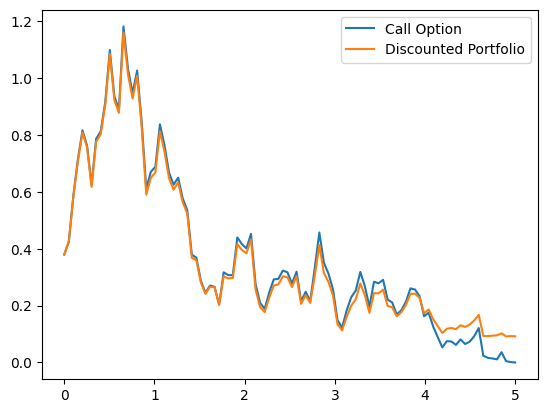

In [19]:
# Graph that output the comparison between the Call option and the discounted portfolio
plt.plot(t, V_BS, label='Call Option')
plt.plot(t, P_discount, label='Discounted Portfolio')
plt.legend()
plt.show()

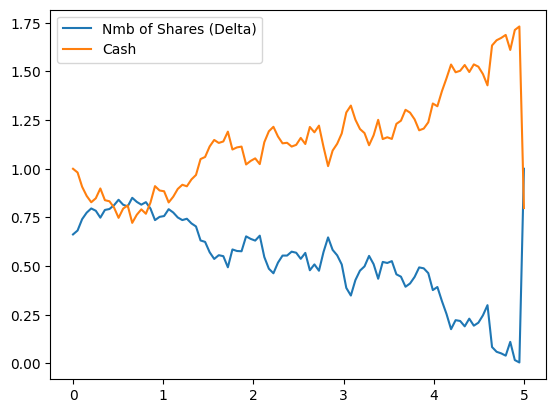

In [20]:
# Graph that show the ratio of holdings in shares and the cash allocation
plt.plot(t, A, label='Nmb of Shares (Delta)')
plt.plot(t, B, label='Cash')
plt.legend()
plt.show()

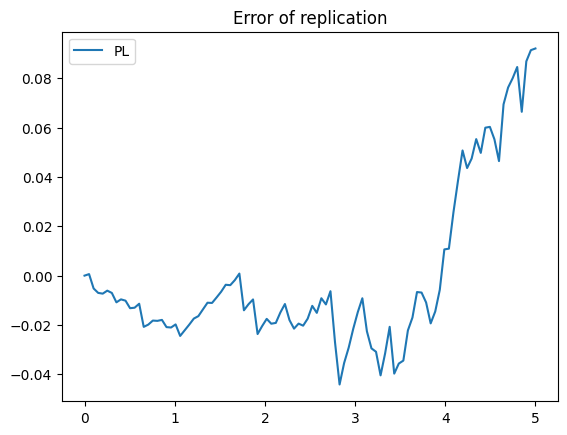

In [21]:
plt.plot(t, P_discount - V_BS, label='PL')
plt.legend()
plt.title('Error of replication')
plt.show()

### C) Expected Value and Variance of the final P&L

In [22]:
# Nmc paths of the Call Option and the Discounted Portfolio

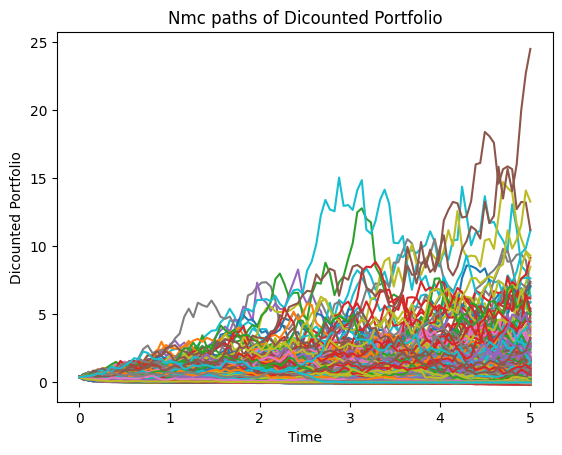

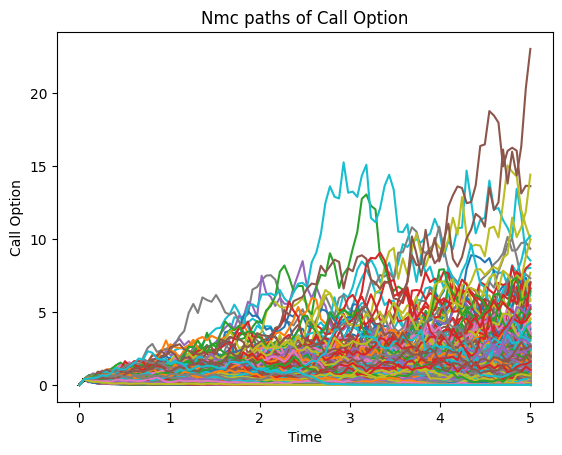

Expected Value of P&L:-0.08467992849337339
Variance of P&L:0.078108230679907


In [23]:
S = np.zeros((Nmc, N))
A = np.zeros((Nmc, N))
B = np.zeros((Nmc, N))
P = np.zeros((Nmc, N))
V_BS = np.zeros((Nmc, N))
P_discount = np.zeros((Nmc, N))

S[:, 0] = S0
A[:, 0] = A0
B[:, 0] = B0
P[:, 0] = P0
P_discount[:, 0] = Call_BS(t0, S0, K, T, r, sigma)


for i in range(N-1):
    S[:, i+1] = S[:, i] * np.exp((r - 0.5 * sigma**2) * dt + np.sqrt(dt) * sigma * np.random.normal(0, 1, Nmc))
    A[:, i+1] = Delta_BS(t[i+1],S[:, i+1],K,T,r,sigma)
    B[:, i+1] = (A[:, i] - A[:, i+1]) * S[:, i+1] + B[:, i] * (1 + r * dt)
    P[:, i+1] = A[:, i+1] * S[:, i+1] + B[:, i+1] # self-financing condition
    V_BS[:, i+1] = Call_BS(t[i],S[:, i],K,T,r,sigma)
    P_discount[:, i+1] = P[:, i+1] + (Call_BS(t0, S0, K, T, r, sigma) - P0) * np.exp(r * t[i+1])

for i in range(Nmc):
    plt.plot(t, P_discount[i])
    
plt.xlabel('Time')
plt.ylabel('Dicounted Portfolio')
plt.title('Nmc paths of Dicounted Portfolio')
plt.show()

for i in range(Nmc):
    plt.plot(t, V_BS[i])
    
plt.xlabel('Time')
plt.ylabel('Call Option')
plt.title('Nmc paths of Call Option')
plt.show()

exptd = np.mean(P_discount[:,-1] - V_BS[:,-1])
var = np.var(P_discount[:,-1] - V_BS[:,-1])
print(f"Expected Value of P&L:{exptd}")
print(f"Variance of P&L:{var}")

/var/folders/17/qc27rbtn21z7zzm339g7gth80000gn/T/ipykernel_24711/121615589.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


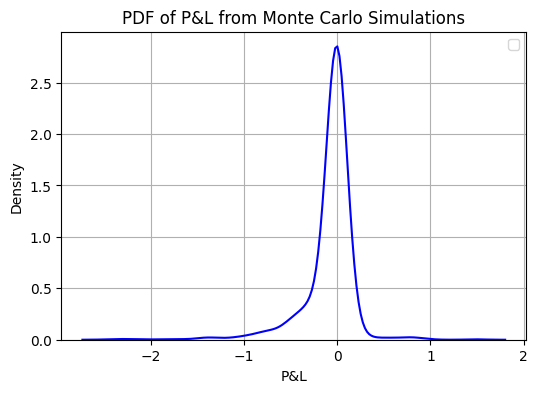

In [24]:
 # Cumulative distribution function & Probability density function of P&L
PnL = P_discount[:,-1] - V_BS[:,-1]
plt.figure(figsize=(6, 4))
sns.kdeplot(PnL, bw_adjust=1.5, color='blue')
plt.title('PDF of P&L from Monte Carlo Simulations')
plt.xlabel('P&L')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

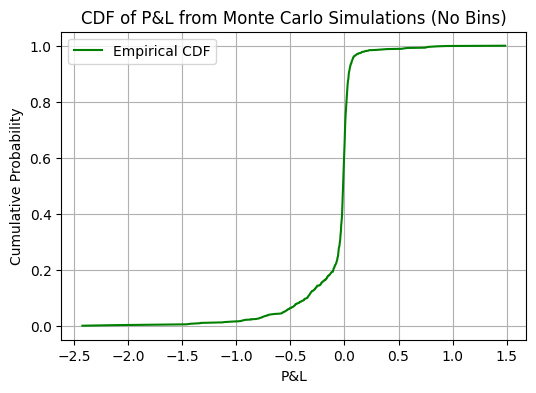

In [25]:
PnL_sorted = np.sort(PnL)
cdf = np.arange(1, len(PnL_sorted) + 1) / len(PnL_sorted)

plt.figure(figsize=(6, 4))
plt.plot(PnL_sorted, cdf, color='green', label="Empirical CDF")
plt.title('CDF of P&L from Monte Carlo Simulations (No Bins)')
plt.xlabel('P&L')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

### D) Impact of trading frequency on PnL

In [26]:
def TradingFrequency(NTrading):
    S = np.zeros((Nmc, N))
    A = np.zeros((Nmc, N))
    B = np.zeros((Nmc, N))
    P = np.zeros((Nmc, N))
    V_BS = np.zeros((Nmc, N))
    P_discount = np.zeros((Nmc, N))
    PnL = np.zeros(Nmc)
    
    S[:, 0] = S0
    A[:, 0] = A0
    B[:, 0] = B0
    P[:, 0] = P0
    P_discount[:, 0] = Call_BS(t0, S0, K, T, r, sigma) 
    
    
    for i in range(N-1):
        if np.mod(i, NTrading) == 0: # Hedging at specified time steps / trading frequency
            S[:, i+1] = S[:, i] * np.exp((r - 0.5 * sigma**2) * dt + np.sqrt(dt) * sigma * np.random.normal(0, 1, Nmc))
            A[:, i+1] = Delta_BS(t[i+1],S[:, i+1],K,T,r,sigma)
            B[:, i+1] = (A[:, i] - A[:, i+1]) * S[:, i+1] + B[:, i] * (1 + r * dt)
            P[:, i+1] = A[:, i+1] * S[:, i+1] + B[:, i+1] # self-financing condition
            V_BS[:, i+1] = Call_BS(t[i],S[:, i],K,T,r,sigma)
            P_discount[:, i+1] = P[:, i+1] + (Call_BS(t0, S0, K, T, r, sigma) - P0) * np.exp(r * t[i+1])
        else:
            S[:, i+1] = S[:, i] * np.exp((r - 0.5 * sigma**2) * dt + np.sqrt(dt) * sigma * np.random.normal(0, 1, Nmc))
            A[:, i+1] = A[:, i]
            B[:, i+1] = B[:, i]
            P[:, i+1] = A[:, i+1] * S[:, i+1] + B[:, i+1]
            V_BS[:, i+1] = Call_BS(t[i],S[:, i],K,T,r,sigma)
            P_discount[:, i+1] = P[:, i+1] + (Call_BS(t0, S0, K, T, r, sigma) - P0) * np.exp(r * t[i+1])
    
    PnL = P_discount[:,-1] - V_BS[:,-1]
    return PnL
    

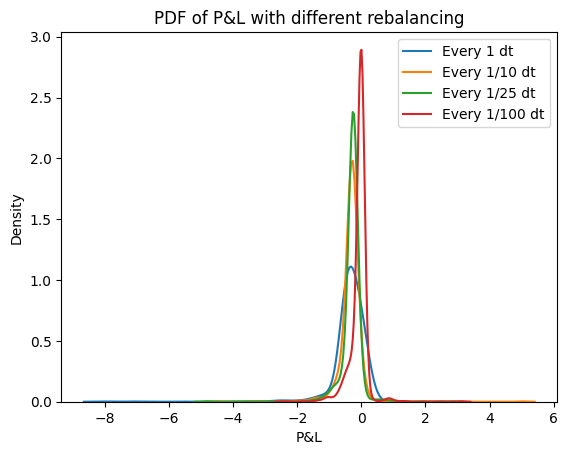

In [27]:
from fractions import Fraction
NTrading = [100, 10, 4, 1]
for i in NTrading:
    sns.kdeplot(TradingFrequency(i), bw_adjust=1.5, label=f"Every {Fraction(i, N)} dt")
plt.title('PDF of P&L with different rebalancing')
plt.xlabel('P&L')
plt.ylabel('Density')
plt.legend()
plt.show()   


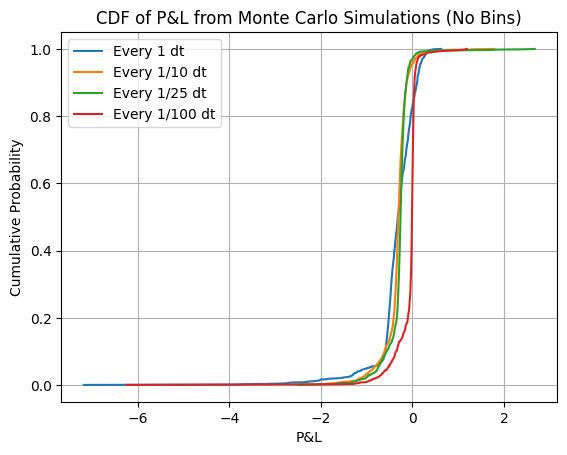

In [28]:
for i in NTrading:
    PnL_sorted = np.sort(TradingFrequency(i))
    cdf = np.arange(1, len(PnL_sorted) + 1) / len(PnL_sorted)
    plt.plot(PnL_sorted, cdf, label=f"Every {Fraction(i, N)} dt")

plt.title('CDF of P&L from Monte Carlo Simulations (No Bins)')
plt.xlabel('P&L')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()